In [1]:
import numpy as np

data = np.load("data_squareRoom.npy")
print(data.shape)
# format: 22000 Bilder, ZeilenxSpaltenxRGB Channel

(22000, 70, 210, 3)


In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(data[0]) # mitte unten ist immer bodentextur
plt.figure()
plt.imshow(data[0][:30,:100])

KeyboardInterrupt: 

In [63]:
# images to video
import cv2
data_rgb = (data*255).astype(np.uint8)
height, width = data.shape[1:3]
fourcc = cv2.VideoWriter_fourcc(*'ffv1')
video = cv2.VideoWriter("coolVideo.mkv", fourcc, 5, (width,height))
for i,frame in enumerate(data_rgb):
    video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
video.release()

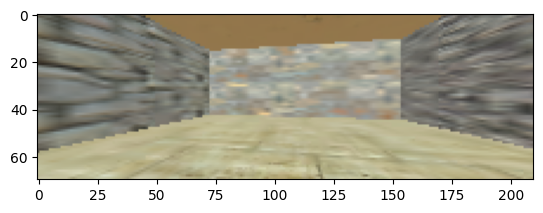

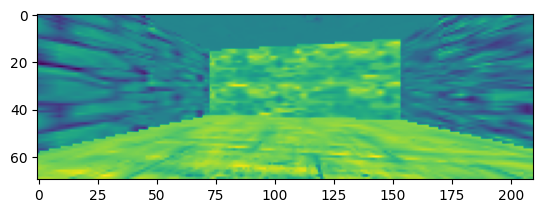

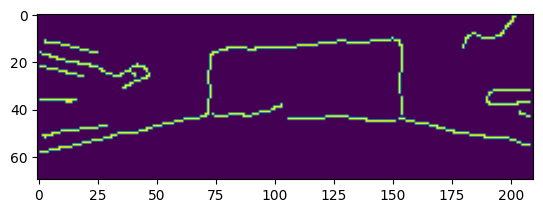

In [3]:
from skimage import feature
from skimage.color import rgb2gray
import cv2
edges = feature.canny(rgb2gray(data[1]), sigma=2.25)
plt.figure()
plt.imshow(data[1])
plt.figure()
plt.imshow(rgb2gray(data[1]))
plt.figure()
plt.imshow(edges)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
x_train, x_test = train_test_split(data, test_size=0.15, random_state=177013)
print(x_train.shape, x_test.shape)

(18700, 70, 210, 3) (3300, 70, 210, 3)


Model: "conv_lstm_autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 3)              │       193,491 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,491 (755.82 KB)

 Trainable params: 193,491 (755.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.5362 - loss: 0.0192
Epoch 2/6
230/230 ━━━━━━━━━━━━━━━━━━━━ 66s 288ms/step - accuracy: 0.7742 - loss: 0.0112
Epoch 3/6
230/230 ━━━━━━━━━━━━━━━━━━━━ 66s 285ms/step - accuracy: 0.7742 - loss: 0.0105
Epoch 4/6
230/230 ━━━━━━━━━━━━━━━━━━━━ 71s 308ms/step - accuracy: 0.7750 - loss: 0.0102
Epoch 5/6
230/230 ━━━━━━━━━━━━━━━━━━━━ 65s 283ms/step - accuracy: 0.7716 - loss: 0.0100
Epoch 6/6
230/230 ━━━━━━━━━━━━━━━━━━━━ 66s 288ms/step - accuracy: 0.7688 - loss: 0.0099
Input shape: (7333, 1, 70, 210, 3)
Output shape: (1, 1, 70, 210, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Output values: [[[[[0.55894107 0.55461216 0.49713176]
    [0.5958201  0.5768824  0.4956342 ]
    [0.5992828  0.57795167 0.4973249 ]
    ...
    [0.6483123  0.6238207  0.5280961 ]
    [0.6471403  0.6165817  0.5312971 ]
    [0.5992812  0.58718884 0.5167858 ]]

   [[0.59146035 0.5842381  0.5151417 ]
    [0.6417736  0.61409026 0.51876   ]
    [0.6419835  0.61505556 0

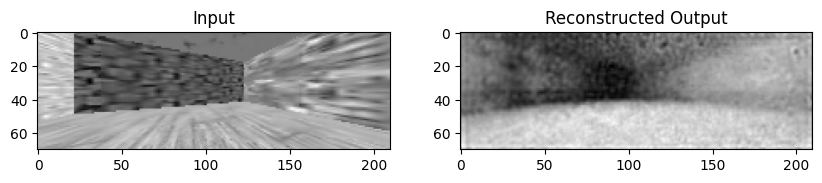

In [5]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, Model

class ConvLSTMAutoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(ConvLSTMAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.ConvLSTM2D(8, (3, 3), activation="relu", padding="same", return_sequences=True, input_shape=shape),
            layers.MaxPooling3D((1, 2, 2), padding="same"),
            layers.ConvLSTM2D(16, (3, 3), activation="relu", padding="same", return_sequences=False),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(np.prod((shape[0], shape[1]//2, shape[2]//2, 4)), activation='relu'),
            layers.Reshape((shape[0], shape[1]//2, shape[2]//2, 4)),
            layers.UpSampling3D((1, 2, 2)),
            layers.Conv3DTranspose(8, (3, 3, 3), activation='relu', padding="same"),
            layers.Conv3DTranspose(shape[3], (3, 3, 3), activation='sigmoid', padding="same")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Assuming x_train and x_test are your datasets with shape (num_samples, time_steps, height, width, channels)  # Example data with original dimensions
data_subset = data[:len(data)//3]  # Take only a tenth of the data
data_subset = np.expand_dims(data_subset, axis=1)
shape = data_subset.shape[1:]  # (time_steps, height, width, channels)
latent_dim = 3
autoencoder = ConvLSTMAutoencoder(latent_dim, shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["accuracy"])

# Print model summary
autoencoder.summary()

# Fit the model
history = autoencoder.fit(data_subset, data_subset, epochs=6, shuffle=True)

# Check input and output shapes
print("Input shape:", data_subset.shape)
sample_input = data_subset[:1]  # Take one sample from the data
sample_output = autoencoder(sample_input)
print("Output shape:", sample_output.shape)

# Run a test prediction
sample_output = autoencoder.predict(sample_input)
print("Output values:", sample_output)

# Plotting the input and output
plt.figure(figsize=(10, 5))

# Plot the first frame of the input and output for comparison
plt.subplot(1, 2, 1)
plt.imshow(sample_input[0, 0, :, :, 0], cmap='gray')
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(sample_output[0, 0, :, :, 0], cmap='gray')
plt.title('Reconstructed Output')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Output values: [[[[[0.55894107 0.55461216 0.49713176]
    [0.5958201  0.5768824  0.4956342 ]
    [0.5992828  0.57795167 0.4973249 ]
    ...
    [0.6483123  0.6238207  0.5280961 ]
    [0.6471403  0.6165817  0.5312971 ]
    [0.5992812  0.58718884 0.5167858 ]]

   [[0.59146035 0.5842381  0.5151417 ]
    [0.6417736  0.61409026 0.51876   ]
    [0.6419835  0.61505556 0.51871854]
    ...
    [0.7100539  0.6730095  0.5646614 ]
    [0.70318866 0.6690545  0.5734945 ]
    [0.63853425 0.6178538  0.5455054 ]]

   [[0.60796344 0.59505516 0.52750987]
    [0.6540135  0.62798315 0.53354263]
    [0.6469291  0.6221505  0.5312179 ]
    ...
    [0.6955276  0.65743285 0.5521662 ]
    [0.70123917 0.6674212  0.56590575]
    [0.6472401  0.6217452  0.5482896 ]]

   ...

   [[0.69050986 0.666747   0.55868816]
    [0.7733068  0.73146904 0.60021824]
    [0.7585997  0.7150833  0.58800036]
    ...
    [0.7593235  0.71840405 0.57214373]
    [0.7640119  0.72339374 0.5591086 ]
    

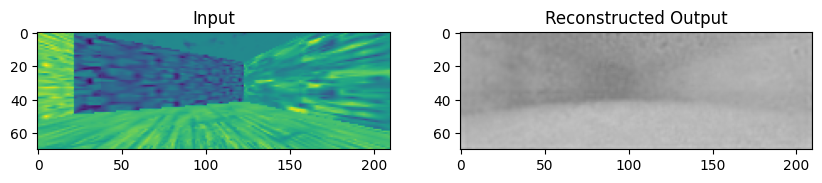

In [ ]:
import cv2

# Run a test prediction
sample_output = autoencoder.predict(sample_input)
print("Output values:", sample_output)

# Plotting the input and output
plt.figure(figsize=(10, 5))

# Plot the first frame of the input and output for comparison
plt.subplot(1, 2, 1)
plt.imshow(sample_input[0, 0, :, :, 0], cmap='gray')
plt.title('Input')

frame = cv2.cvtColor(sample_output[0, 0, :, :, 0], cv2.COLOR_RGB2BGR)
plt.subplot(1, 2, 2)
plt.imshow(frame)
plt.title('Reconstructed Output')

plt.show()

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
    layers.Dense(117600 , activation='relu'),
    layers.Reshape((35, 105, 32)),
    layers.UpSampling2D((2,2)),
    layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', strides=(1,1), padding="same")
])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

shape = x_test.shape[1:]
latent_dim = 16
autoencoder = Autoencoder(latent_dim, shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["accuracy"])
history = autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.7201 - loss: 0.0129 - val_accuracy: 0.7434 - val_loss: 0.0082
Epoch 2/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7393 - loss: 0.0081 - val_accuracy: 0.7373 - val_loss: 0.0079
Epoch 3/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.7379 - loss: 0.0079 - val_accuracy: 0.7415 - val_loss: 0.0078
Epoch 4/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.7401 - loss: 0.0078 - val_accuracy: 0.7422 - val_loss: 0.0077
Epoch 5/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.7437 - loss: 0.0077 - val_accuracy: 0.7434 - val_loss: 0.0076
Epoch 6/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.7443 - loss: 0.0075 - val_accuracy: 0.7475 - val_loss: 0.0075
Epoch 7/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7460 - loss: 0.0075 - val_accuracy: 0.7441 - val_loss: 0.0074
Epoch 8/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.7459 - loss: 0.0074 - 

In [14]:
# Training und Validation Accuracy aus history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

NameError: name 'history' is not defined

Model: "autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 3)              │       353,699 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 70, 210, 3)     │       471,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,474,900 (9.44 MB)

 Trainable params: 824,966 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,649,934 (6.29 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 70, 210, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 105, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 117600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │       352,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,699 (1.35 MB)

 Trainable params: 353,699 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 117600)         │       470,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 35, 105, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 70, 210, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 70, 210, 3)     │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,267 (1.80 MB)

 Trainable params: 471,267 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

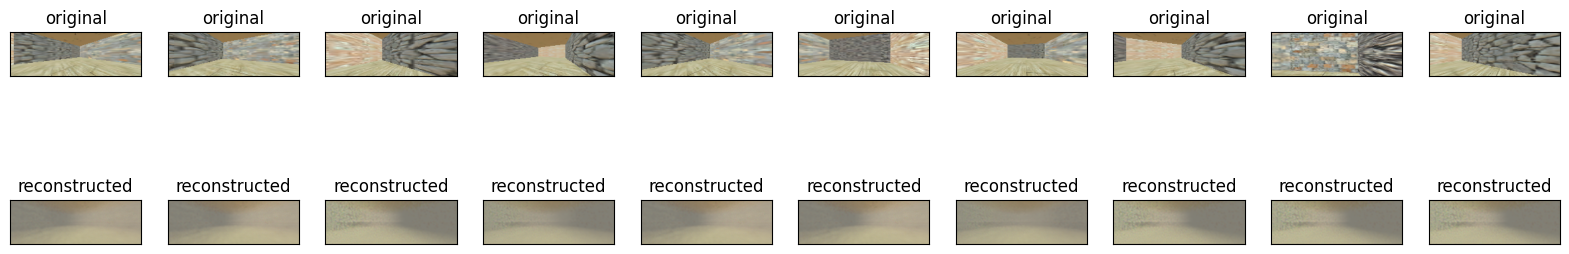

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()